## Importação de bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import warnings
import io
warnings.filterwarnings('ignore')

## Análise da base de dados

### Leitura do Dataset

In [ ]:
# Carrega o dataset
df = pd.read_excel('capec_stride_dataset.xlsx')
display(df)

,CAPEC,Name,Description,Scopes,Impacts,Label
0,CAPEC-1,Accessing Functionality Not Properly Constrain...,"In applications, particularly web applications...","['Confidentiality', 'Access Control', 'Authori...",['Gain Privileges'],['Elevation of Privilege']
1,CAPEC-10,Buffer Overflow via Environment Variables,This attack pattern involves causing a buffer ...,"['Availability', 'Confidentiality', 'Integrity...","['Unreliable Execution', 'Execute Unauthorized...",['Tampering']
2,CAPEC-100,Overflow Buffers,Buffer Overflow attacks target improper or mis...,"['Availability', 'Confidentiality', 'Integrity...","['Unreliable Execution', 'Execute Unauthorized...",['Tampering']
3,CAPEC-101,Server Side Include (SSI) Injection,An attacker can use Server Side Include (SSI) ...,"['Confidentiality', 'Confidentiality', 'Integr...","['Read Data', 'Execute Unauthorized Commands']",['Elevation of Privilege']
4,CAPEC-102,Session Sidejacking,Session sidejacking takes advantage of an unen...,"['Confidentiality', 'Access Control', 'Authori...","['Gain Privileges', 'Modify Data', 'Read Data'...",['Elevation of Privilege']
...,...,...,...,...,...,...
539,CAPEC-94,Adversary in the Middle (AiTM),An adversary targets the communication between...,"['Integrity', 'Confidentiality', 'Access Contr...","['Modify Data', 'Gain Privileges', 'Read Data']",['Elevation of Privilege']
540,CAPEC-95,WSDL Scanning,This attack targets the WSDL interface made av...,['Confidentiality'],['Read Data'],['Information Disclosure']
541,CAPEC-96,Block Access to Libraries,An application typically makes calls to functi...,"['Availability', 'Confidentiality', 'Confident...","['Alter Execution Logic', 'Other', 'Bypass Pro...",['Denial of Service']
542,CAPEC-97,Cryptanalysis,Cryptanalysis is a process of finding weakness...,['Confidentiality'],['Read Data'],['Information Disclosure']


### Contagem dos atributos sem categoria

In [ ]:
# Função para contar atributos únicos em uma coluna de listas representadas como strings
def count_unique_attributes(df, column_name):
    all_attributes = []
    for _, row in df.iterrows():
        if isinstance(row[column_name], str):
            try:
                attributes = ast.literal_eval(row[column_name])
                if isinstance(attributes, list):
                    all_attributes.extend(attributes)
            except:
                pass # Ignora linhas com formato inválido

    return Counter(all_attributes)

# Conta os atributos únicos para Scopes e Impacts
total_scope_counts = count_unique_attributes(df, 'Scopes')
total_impact_counts = count_unique_attributes(df, 'Impacts')

# Exibe os resultados
print("Contagem total de atributos em Scopes:")
print("-" * 50)
for attribute, count in total_scope_counts.most_common():
    print(f"{attribute} = {count}")
print("-" * 50)

print("\nContagem total de atributos em Impacts:")
print("-" * 50)
for attribute, count in total_impact_counts.most_common():
    print(f"{attribute} = {count}")
print("-" * 50)

Contagem total de atributos em Scopes:
--------------------------------------------------
Confidentiality = 466
Integrity = 227
Authorization = 217
Access Control = 189
Availability = 172
Authentication = 32
Accountability = 19
Non-Repudiation = 16
Other = 5
--------------------------------------------------

Contagem total de atributos em Impacts:
--------------------------------------------------
Read Data = 187
Gain Privileges = 135
Execute Unauthorized Commands = 121
Modify Data = 119
Bypass Protection Mechanism = 76
Other = 72
Hide Activities = 45
Unreliable Execution = 42
Resource Consumption = 34
Alter Execution Logic = 12
--------------------------------------------------


### Contagem dos atributos por categoria STRIDE

In [ ]:
# Função para extrair e contar elementos de listas representadas como strings
def extract_and_count(df, column_name, categories):
    result = {category: Counter() for category in categories}

    for _, row in df.iterrows():
        if isinstance(row['Label'], str) and row[column_name]:
            try:
                labels = ast.literal_eval(row['Label'])
                elements = ast.literal_eval(row[column_name]) if isinstance(row[column_name], str) else []

                for label in labels:
                    for element in elements:
                        result[label][element] += 1
            except:
                pass

    return result

# Define as categorias STRIDE
stride_categories = ['Spoofing', 'Tampering', 'Repudiation', 'Information Disclosure',
                     'Denial of Service', 'Elevation of Privilege']

# Extrai e conta Scopes e Impacts por categoria STRIDE
scope_counts = extract_and_count(df, 'Scopes', stride_categories)
impact_counts = extract_and_count(df, 'Impacts', stride_categories)

# Cria um DataFrames para visualização
def create_count_df(count_dict, categories):
    all_keys = set()
    for category in categories:
        all_keys.update(count_dict[category].keys())

    result_df = pd.DataFrame(index=sorted(all_keys), columns=categories)

    for category in categories:
        for key in all_keys:
            result_df.loc[key, category] = count_dict[category].get(key, 0)

    return result_df

scope_df = create_count_df(scope_counts, stride_categories)
impact_df = create_count_df(impact_counts, stride_categories)

# Exibe os resultados
print("Distribuição de Scopes por categoria STRIDE:")
print("-" * 52)
# Cria uma cópia para printar as colunas com as siglas
scope_df_acronyms = scope_df.copy()
scope_df_acronyms.columns = ['S', 'T', 'R', 'I', 'D', 'E']
print(scope_df_acronyms)
print("-" * 52)

print("\n\nDistribuição de Impacts por categoria STRIDE:")
print("-" * 52)
# Cria uma cópia para printar as colunas com as siglas
impact_df_acronyms = impact_df.copy()
impact_df_acronyms.columns = ['S', 'T', 'R', 'I', 'D', 'E']
print(impact_df_acronyms)
print("-" * 52)

Distribuição de Scopes por categoria STRIDE:
----------------------------------------------------
                  S    T  R    I   D    E
Access Control   14   45  1   46   3   80
Accountability    4    2  0    1   0   12
Authentication    9    2  0    0   0   21
Authorization    18   50  1   45   3  100
Availability     15   74  3    3  28   49
Confidentiality  38  108  3  136   9  172
Integrity        35   83  4    6   2   97
Non-Repudiation   4    1  0    0   0   11
Other             4    0  0    1   0    0
----------------------------------------------------


Distribuição de Impacts por categoria STRIDE:
----------------------------------------------------
                                S   T  R   I   D   E
Alter Execution Logic           2   8  0   0   1   1
Bypass Protection Mechanism     5  12  0  38   1  20
Execute Unauthorized Commands   8  57  1   0   2  53
Gain Privileges                16  35  1   7   2  74
Hide Activities                 2   4  0  38   0   1
Modify Dat

## Pré-processamento dos dados

### Conversão para lista de forma segura

In [ ]:
def safe_literal_eval(val):
        """Converte string de lista para lista Python de forma segura"""
        if pd.isna(val) or val == '[]' or val == '':
            return []
        try:
            if isinstance(val, str):
                return ast.literal_eval(val)
            return val if isinstance(val, list) else []
        except:
            return []

### Pré-processamento

In [ ]:
def preprocess_data(df):
        """Pré-processa os dados CAPEC"""
        # Converte strings de listas para listas Python
        df['Scopes_list'] = df['Scopes'].apply(safe_literal_eval)
        df['Impacts_list'] = df['Impacts'].apply(safe_literal_eval)
        df['Label_list'] = df['Label'].apply(safe_literal_eval)

        # Filtra registros que possuem tanto Scopes quanto Impacts
        df_filtered = df[(df['Scopes_list'].apply(len) > 0) &
                        (df['Impacts_list'].apply(len) > 0)].copy()

        print(f"Registros originais: {len(df)}")
        print(f"Registros após filtro: {len(df_filtered)}")

        # Cria atributos binários para Scopes e Impacts
        mlb_scopes = MultiLabelBinarizer()
        mlb_impacts = MultiLabelBinarizer()

        scopes_binary = mlb_scopes.fit_transform(df_filtered['Scopes_list'])
        impacts_binary = mlb_impacts.fit_transform(df_filtered['Impacts_list'])

        # Combina os atributos
        features = np.hstack([scopes_binary, impacts_binary])

        feature_names = (list(mlb_scopes.classes_) +
                             [f"Impact_{cls}" for cls in mlb_impacts.classes_])

        print(f"Dimensões das features: {features.shape}")
        print(f"Features Scopes: {list(mlb_scopes.classes_)}")
        print(f"Features Impacts: {list(mlb_impacts.classes_)}")

        return df_filtered, features, mlb_scopes, mlb_impacts, feature_names

# Pré-processa os dados
df_filtered, features, mlb_scopes, mlb_impacts, feature_names = preprocess_data(df)

if len(df_filtered) == 0:
    print("❌ Erro: Nenhum registro válido encontrado após o filtro!")

Registros originais: 544
Registros após filtro: 354
Dimensões das features: (354, 19)
Features Scopes: ['Access Control', 'Accountability', 'Authentication', 'Authorization', 'Availability', 'Confidentiality', 'Integrity', 'Non-Repudiation', 'Other']
Features Impacts: ['Alter Execution Logic', 'Bypass Protection Mechanism', 'Execute Unauthorized Commands', 'Gain Privileges', 'Hide Activities', 'Modify Data', 'Other', 'Read Data', 'Resource Consumption', 'Unreliable Execution']


# Construção do Algoritmo Evolutivo

### Parâmetros do Algoritmo Evolutivo

In [ ]:
n_clusters = 6
population_size = 50
generations = 100
mutation_rate = 0.1
crossover_rate = 0.8
elite_size = 5
tournament_size = 3

## Etapas do algoritmo

### Inicialização da população

In [ ]:
def initialize_population(n_samples, population_size, n_clusters, n_features):
        """Inicializa a população de centroides"""
        population = []
        for _ in range(population_size):
            # Cada indivíduo são os centroides dos clusters
            centroids = np.random.rand(n_clusters, n_features)
            population.append(centroids)
        return population

### Avaliação (fitnnes)

In [ ]:
def assign_clusters(data, centroids):
        """Atribui cada ponto ao cluster mais próximo"""
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

In [ ]:
def calculate_fitness(data, centroids, n_clusters):
        """Calcula fitness baseado em múltiplos critérios"""
        labels = assign_clusters(data, centroids)

        # Critério 1: Silhueta (qualidade dos clusters)
        if len(np.unique(labels)) > 1:
            silhouette = silhouette_score(data, labels)
        else:
            silhouette = -1

        # Critério 2: Distribuição equilibrada dos clusters
        cluster_counts = np.bincount(labels, minlength=n_clusters)
        balance = 1 - np.std(cluster_counts) / (np.mean(cluster_counts) + 1e-8)

        # Critério 3: Separação entre centroides
        centroid_distances = []
        for i in range(len(centroids)):
            for j in range(i+1, len(centroids)):
                dist = np.linalg.norm(centroids[i] - centroids[j])
                centroid_distances.append(dist)
        separation = np.mean(centroid_distances) if centroid_distances else 0

        # Fitness combinado (pesos ajustáveis)
        fitness = 0.7 * silhouette + 0.1 * balance + 0.2 * separation
        # fitness = 0.5 * silhouette + 0.3 * balance + 0.2 * separation
        return fitness

In [ ]:
# def calculate_fitness(data, centroids, n_clusters):
#         """Calcula fitness baseado em múltiplos critérios"""
#         labels = assign_clusters(data, centroids)

#         # Critério 1: Silhueta (qualidade dos clusters)
#         if len(np.unique(labels)) > 1:
#             silhouette = silhouette_score(data, labels)
#         else:
#             silhouette = -1

#         # Critério 2: Separação entre centroides
#         centroid_distances = []
#         for i in range(len(centroids)):
#             for j in range(i+1, len(centroids)):
#                 dist = np.linalg.norm(centroids[i] - centroids[j])
#                 centroid_distances.append(dist)
#         separation = np.mean(centroid_distances) if centroid_distances else 0

#         # Fitness combinado (pesos ajustáveis)
#         # Fitness = 0.7 * silhouette + 0.1 * balance + 0.2 * separation
#         fitness = 0.9 * silhouette + 0.1 * separation # Ajuste de pesos após remover balanceamento
#         return fitness

### Cruzamento

In [ ]:
def crossover(parent1, parent2, n_clusters, crossover_rate):
        """Cruzamento entre dois pais"""
        child1 = parent1.copy()
        child2 = parent2.copy()

        if np.random.random() < crossover_rate:
            # Cruzamento por ponto de corte
            cut_point = np.random.randint(1, n_clusters)
            child1[cut_point:] = parent2[cut_point:]
            child2[cut_point:] = parent1[cut_point:]

        return child1, child2

### Mutação

In [ ]:
def mutate(individual, n_clusters, mutation_rate, n_features):
        """Mutação do indivíduo"""
        mutated = individual.copy()

        for i in range(n_clusters):
            if np.random.random() < mutation_rate:
                # Mutação gaussiana
                noise = np.random.normal(0, 0.1, n_features)
                mutated[i] += noise
                # Mantêm valores entre 0 e 1
                mutated[i] = np.clip(mutated[i], 0, 1)

        return mutated

### Seleção dos melhores

In [ ]:
def tournament_selection(fitness_scores, tournament_size):
        """Seleção por torneio"""
        tournament_indices = np.random.choice(len(fitness_scores), tournament_size)
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]
        winner_idx = tournament_indices[np.argmax(tournament_fitness)]
        return winner_idx

### Função principal

In [ ]:
def evolve(data, initialize_population, generations, population_size, elite_size, n_clusters, tournament_size):
        """Algoritmo evolutivo principal"""
        n_features = data.shape[1]
        population = initialize_population(data.shape[0], population_size, n_clusters, n_features)
        fitness_history = []

        print("Iniciando a evolução de gerações...\n")

        for generation in range(generations):
            # Avalia o fitness
            fitness_scores = []
            for individual in population:
                fitness = calculate_fitness(data, individual, n_clusters)
                fitness_scores.append(fitness)

            fitness_history.append(max(fitness_scores))

            # Seleciona os melhores (elitismo)
            sorted_indices = np.argsort(fitness_scores)[::-1]
            elite = [population[i] for i in sorted_indices[:elite_size]]

            # Nova população
            new_population = elite.copy()

            # Gera descendentes
            while len(new_population) < population_size:
                # Seleção por torneio
                parent1_idx = tournament_selection(fitness_scores, tournament_size)
                parent2_idx = tournament_selection(fitness_scores, tournament_size)

                parent1 = population[parent1_idx]
                parent2 = population[parent2_idx]

                # Cruzamento e mutação
                child1, child2 = crossover(parent1, parent2, n_clusters, crossover_rate)
                child1 = mutate(child1, n_clusters, mutation_rate, n_features)
                child2 = mutate(child2, n_clusters, mutation_rate, n_features)

                new_population.extend([child1, child2])

            population = new_population[:population_size]

            if generation % 20 == 0:
                print(f"Geração {generation}: Melhor fitness = {max(fitness_scores):.4f}")

        # Melhor indivíduo
        final_fitness = [calculate_fitness(data, ind, n_clusters) for ind in population]
        best_idx = np.argmax(final_fitness)
        best_individual = population[best_idx]

        print(f"\nEvolução concluída! Melhor fitness final: {max(final_fitness):.4f}")
        return best_individual, fitness_history

### Análise dos clusters

In [ ]:
def analyze_clusters(df_filtered, labels, mlb_scopes, mlb_impacts, feature_names):
    """Analisa e visualiza os resultados dos clusters"""

    # Adiciona labels ao dataframe
    df_result = df_filtered.copy()
    df_result['Cluster'] = labels

    print("=== ANÁLISE DOS CLUSTERS ===\n")

    # Análise por cluster
    stride_categories = ['Spoofing', 'Tampering', 'Repudiation', 'Information Disclosure',
                        'Denial of Service', 'Elevation of Privilege']

    cluster_analysis = {}

    for cluster_id in range(6):
        cluster_data = df_result[df_result['Cluster'] == cluster_id]
        print(f"CLUSTER {cluster_id} ({len(cluster_data)} registros):")
        print("-" * 50)

        # Scopes mais frequentes
        all_scopes = []
        for scopes_list in cluster_data['Scopes_list']:
            all_scopes.extend(scopes_list)

        scope_counts = Counter(all_scopes)
        print("Top 5 Scopes:")
        for scope, count in scope_counts.most_common(5):
            percentage = (count / len(cluster_data)) * 100
            print(f"  {scope}: {count} ({percentage:.1f}%)")

        # Impacts mais frequentes
        all_impacts = []
        for impacts_list in cluster_data['Impacts_list']:
            all_impacts.extend(impacts_list)

        impact_counts = Counter(all_impacts)
        print("\nTop 5 Impacts:")
        for impact, count in impact_counts.most_common(5):
            percentage = (count / len(cluster_data)) * 100
            print(f"  {impact}: {count} ({percentage:.1f}%)")

        # Labels STRIDE mais frequentes
        all_labels = []
        for labels_list in cluster_data['Label_list']:
            all_labels.extend(labels_list)

        label_counts = Counter(all_labels)
        print("\nCategorias STRIDE:")
        for label, count in label_counts.most_common():
            percentage = (count / len(cluster_data)) * 100
            print(f"  {label}: {count} ({percentage:.1f}%)")

        cluster_analysis[cluster_id] = {
            'size': len(cluster_data),
            'top_scopes': scope_counts.most_common(3),
            'top_impacts': impact_counts.most_common(3),
            'stride_labels': label_counts.most_common()
        }

        print("\n" + "="*70 + "\n")

    return df_result, cluster_analysis

### Plotagem de resultados

In [ ]:
def plot_results(fitness_history, df_result, cluster_analysis):
    """Plota os resultados"""

    # Cria a figura com 3 linhas e 2 colunas, onde a última linha tem apenas um subplot
    fig = plt.figure(figsize=(15, 18))

    # Adiciona os subplots 2x2 na parte superior
    ax1 = fig.add_subplot(3, 2, 1)
    ax2 = fig.add_subplot(3, 2, 2)
    ax3 = fig.add_subplot(3, 2, 3)
    ax4 = fig.add_subplot(3, 2, 4)

    # Adiciona o subplot para o heatmap na parte inferior, abrangendo as duas colunas
    ax5 = fig.add_subplot(3, 1, 3)


    # 1. Evolução do fitness
    ax1.plot(fitness_history, 'b-', linewidth=2)
    ax1.set_title('Evolução do Fitness', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Geração')
    ax1.set_ylabel('Fitness')
    ax1.grid(True, alpha=0.3)

    # 2. Distribuição dos clusters
    cluster_sizes = [cluster_analysis[i]['size'] for i in range(6)]
    colors = plt.cm.Set3(np.linspace(0, 1, 6))

    ax2.bar(range(6), cluster_sizes, color=colors)
    ax2.set_title('Distribuição dos Clusters', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Cluster ID')
    ax2.set_ylabel('Número de Registros')
    ax2.set_xticks(range(6))

    # 3. Top Scopes por Cluster
    top_scopes_data = {}
    for cluster_id in range(6):
        cluster_data = df_result[df_result['Cluster'] == cluster_id]
        all_scopes = []
        for scopes_list in cluster_data['Scopes_list']:
            all_scopes.extend(scopes_list)
        scope_counts = Counter(all_scopes)
        top_scopes_data[cluster_id] = scope_counts.most_common(3)

    # 4. Top Impacts por Cluster
    top_impacts_data = {}
    for cluster_id in range(6):
        cluster_data = df_result[df_result['Cluster'] == cluster_id]
        all_impacts = []
        for impacts_list in cluster_data['Impacts_list']:
            all_impacts.extend(impacts_list)
        impact_counts = Counter(all_impacts)
        top_impacts_data[cluster_id] = impact_counts.most_common(3)

    # Cria gráfico de barras para os melhores Scopes
    scopes_list = []
    cluster_ids = []
    counts = []

    for cluster_id, scopes in top_scopes_data.items():
        for scope, count in scopes:
            scopes_list.append(f"C{cluster_id}: {scope[:15]}...")
            cluster_ids.append(cluster_id)
            counts.append(count)

    colors_scopes = [plt.cm.Set3(i/6) for i in cluster_ids]
    ax3.barh(range(len(scopes_list)), counts, color=colors_scopes)
    ax3.set_title('Top 3 Scopes por Cluster', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Frequência')
    ax3.set_yticks(range(len(scopes_list)))
    ax3.set_yticklabels(scopes_list, fontsize=8)

    # Cria gráfico de barras para os melhores Impacts
    impacts_list = []
    cluster_ids = []
    counts = []

    for cluster_id, impacts in top_impacts_data.items():
        for impact, count in impacts:
            impacts_list.append(f"C{cluster_id}: {impact[:15]}...")
            cluster_ids.append(cluster_id)
            counts.append(count)

    colors_impacts = [plt.cm.Set3(i/6) for i in cluster_ids]
    ax4.barh(range(len(impacts_list)), counts, color=colors_impacts)
    ax4.set_title('Top 3 Impacts por Cluster', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Frequência')
    ax4.set_yticks(range(len(scopes_list)))
    ax4.set_yticklabels(impacts_list, fontsize=8)

    # 5. Mapa de calor de STRIDE por Cluster
    stride_categories = ['Spoofing', 'Tampering', 'Repudiation', 'Information Disclosure',
                        'Denial of Service', 'Elevation of Privilege']

    stride_matrix = np.zeros((6, len(stride_categories)))

    for cluster_id in range(6):
        cluster_data = df_result[df_result['Cluster'] == cluster_id]
        for idx, stride_cat in enumerate(stride_categories):
            count = sum(1 for labels_list in cluster_data['Label_list']
                       if stride_cat in labels_list)
            stride_matrix[cluster_id, idx] = count / len(cluster_data) if len(cluster_data) > 0 else 0

    im = ax5.imshow(stride_matrix, cmap='YlOrRd', aspect='auto')
    ax5.set_title('Distribuição STRIDE por Cluster', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Categorias STRIDE')
    ax5.set_ylabel('Cluster ID')
    ax5.set_xticks(range(len(stride_categories)))
    ax5.set_xticklabels(stride_categories, rotation=45, ha='right')
    ax5.set_yticks(range(6))

    # Adiciona valores no mapa de calor
    for i in range(6):
        for j in range(len(stride_categories)):
            text = ax5.text(j, i, f'{stride_matrix[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)

    plt.colorbar(im, ax=ax5)

    plt.tight_layout()
    plt.show()

### Previsão

In [ ]:
def predict(data, best_individual):
        """Prediz clusters usando o melhor indivíduo"""
        if best_individual is None:
            raise ValueError("Modelo não foi treinado ainda!")
        return assign_clusters(data, best_individual)

## Execução do código

### Execução das gerações

In [ ]:
"""Função principal para executar o algoritmo evolutivo"""
print("="*80)
print("ALGORITMO EVOLUTIVO PARA CLUSTERIZAÇÃO CAPEC-STRIDE")
print("="*80)

# Executa o algoritmo evolutivo
best_centroids, fitness_history = evolve(features, initialize_population, generations,
                        population_size, elite_size, n_clusters, tournament_size)

# Obtenção dos labels finais
best_individual = best_centroids
final_labels = predict(features, best_individual)

ALGORITMO EVOLUTIVO PARA CLUSTERIZAÇÃO CAPEC-STRIDE
Iniciando a evolução de gerações...

Geração 0: Melhor fitness = 0.5035
Geração 20: Melhor fitness = 0.6450
Geração 40: Melhor fitness = 0.6994
Geração 60: Melhor fitness = 0.7289
Geração 80: Melhor fitness = 0.7577

Evolução concluída! Melhor fitness final: 0.7835


### Resultados

In [ ]:
# Análise dos resultados
df_result, cluster_analysis = analyze_clusters(
    df_filtered, final_labels, mlb_scopes, mlb_impacts, feature_names)

=== ANÁLISE DOS CLUSTERS ===

CLUSTER 0 (70 registros):
--------------------------------------------------
Top 5 Scopes:
  Confidentiality: 85 (121.4%)
  Integrity: 37 (52.9%)
  Availability: 29 (41.4%)
  Access Control: 2 (2.9%)

Top 5 Impacts:
  Read Data: 71 (101.4%)
  Modify Data: 22 (31.4%)
  Execute Unauthorized Commands: 20 (28.6%)
  Unreliable Execution: 9 (12.9%)
  Resource Consumption: 7 (10.0%)

Categorias STRIDE:
  Information Disclosure: 34 (48.6%)
  Tampering: 16 (22.9%)
  Elevation of Privilege: 12 (17.1%)
  Spoofing: 6 (8.6%)
  Denial of Service: 1 (1.4%)
  Repudiation: 1 (1.4%)


CLUSTER 1 (45 registros):
--------------------------------------------------
Top 5 Scopes:
  Confidentiality: 91 (202.2%)
  Access Control: 45 (100.0%)
  Authorization: 45 (100.0%)
  Availability: 10 (22.2%)
  Integrity: 7 (15.6%)

Top 5 Impacts:
  Bypass Protection Mechanism: 42 (93.3%)
  Hide Activities: 39 (86.7%)
  Other: 22 (48.9%)
  Read Data: 20 (44.4%)
  Unreliable Execution: 5 (11.1%)

### Visualização dos resultados

Calculando as métricas de qualidade...
✓ Silhouette Score: 0.2604
✓ Distribuição dos clusters: [70 45 63 48 53 75]
✓ Índice de balanceamento: 0.8110

Gerando as visualizações...


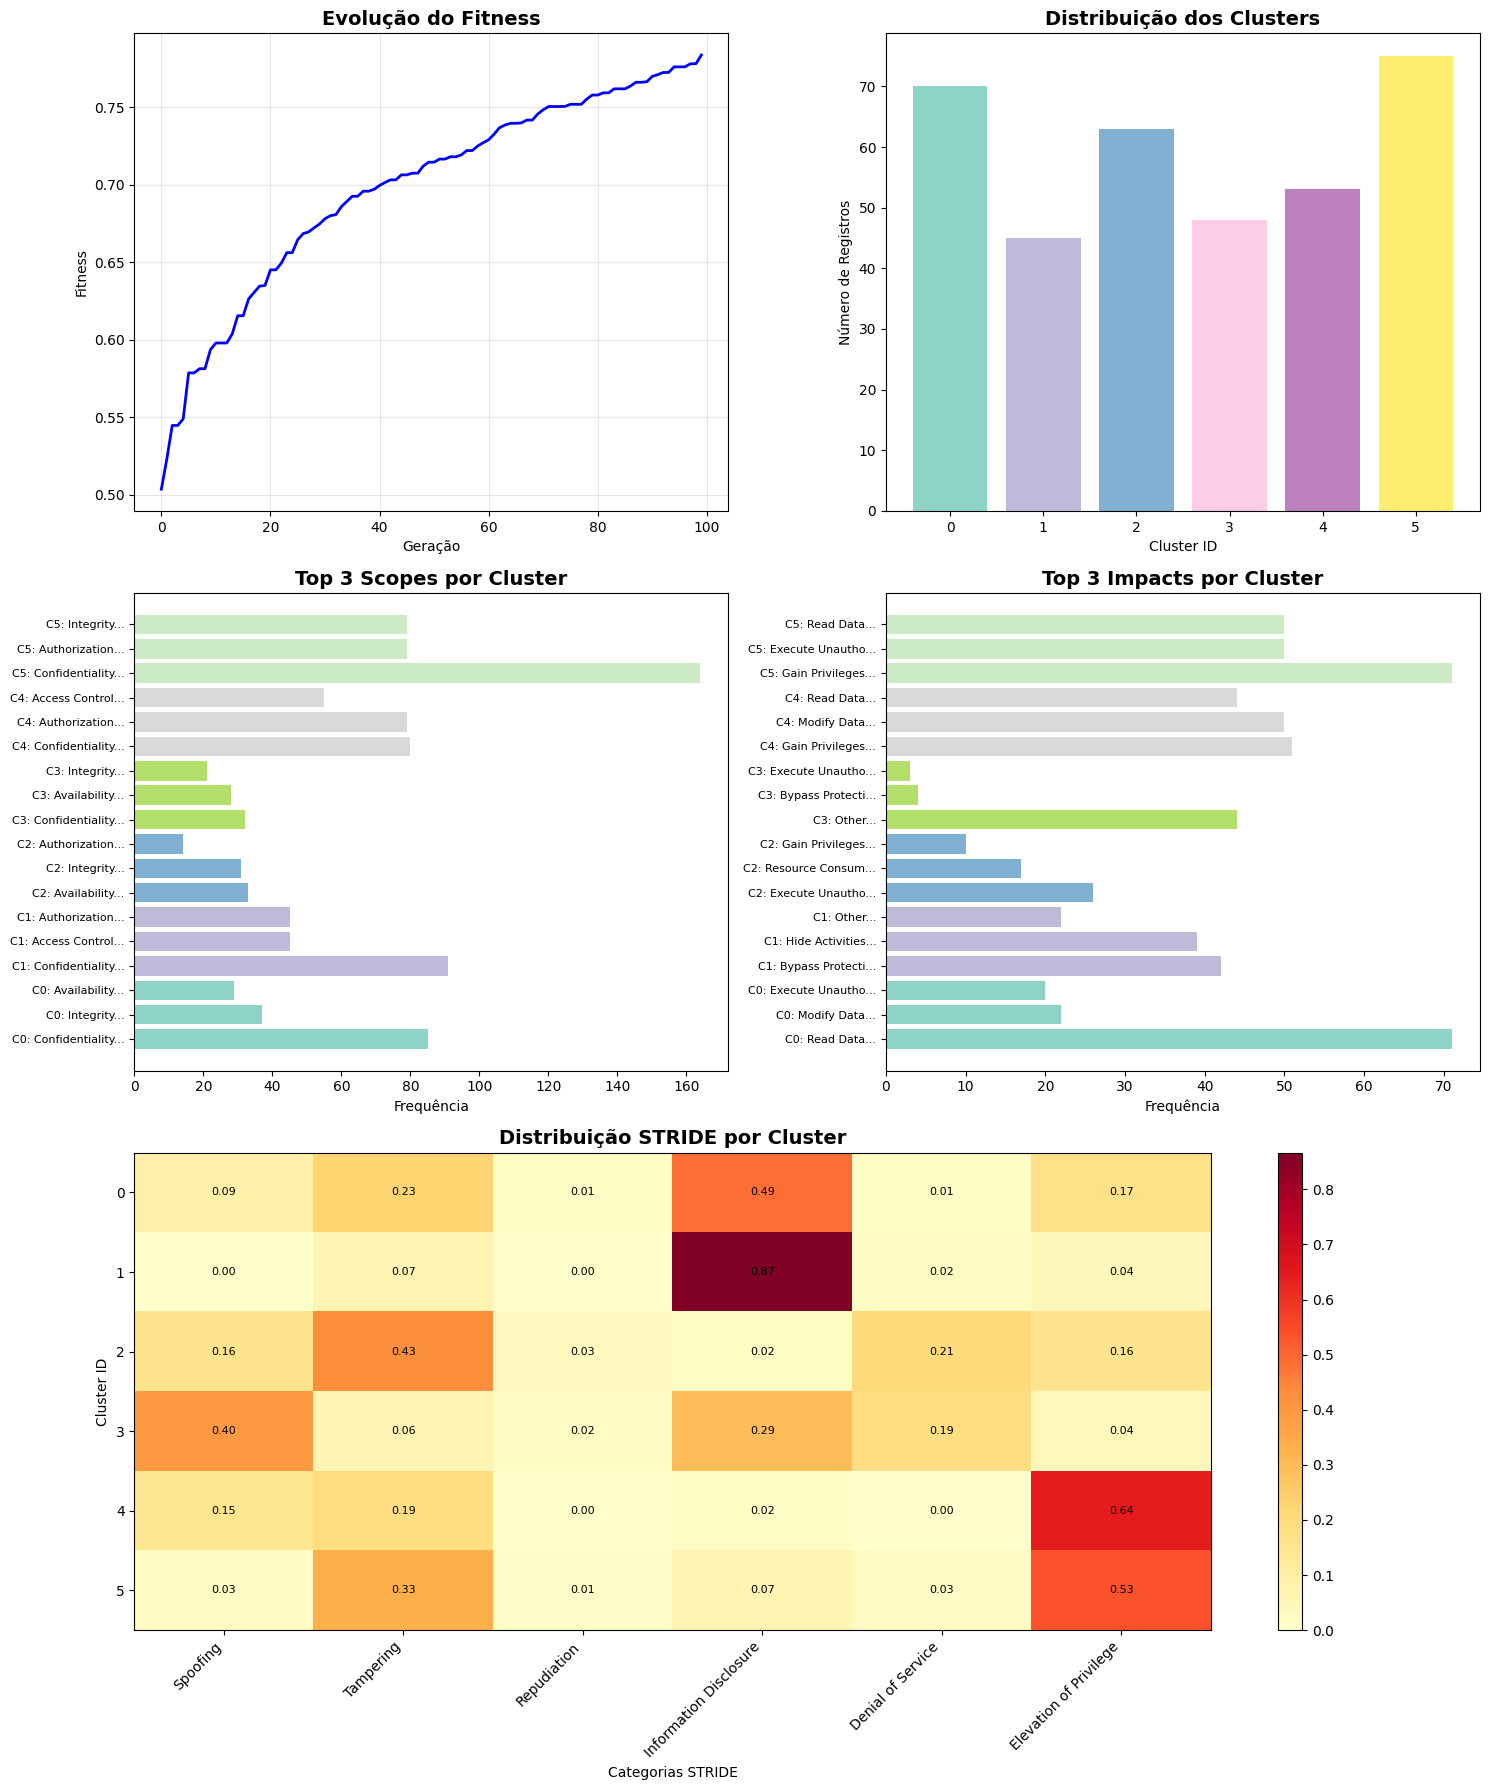

In [ ]:
# Calcula as métricas de qualidade
print("Calculando as métricas de qualidade...")
if len(np.unique(final_labels)) > 1:
    silhouette = silhouette_score(features, final_labels)
    print(f"✓ Silhouette Score: {silhouette:.4f}")

# Distribuição dos clusters
cluster_distribution = np.bincount(final_labels)
print(f"✓ Distribuição dos clusters: {cluster_distribution}")

# Verifica o balanceamento
std_dev = np.std(cluster_distribution)
mean_size = np.mean(cluster_distribution)
balance_ratio = 1 - (std_dev / mean_size)
print(f"✓ Índice de balanceamento: {balance_ratio:.4f}")

# Plota os resultados
print("\nGerando as visualizações...")
plot_results(fitness_history, df_result, cluster_analysis)

### Associações STRIDE-CLuster

In [ ]:
# Análise detalhada das associações STRIDE
print("ANÁLISE DE ASSOCIAÇÕES STRIDE-CLUSTER:")
print("="*60)

stride_categories = ['Spoofing', 'Tampering', 'Repudiation', 'Information Disclosure',
                    'Denial of Service', 'Elevation of Privilege']

for cluster_id in range(6):
    cluster_data = df_result[df_result['Cluster'] == cluster_id]
    print(f"\n🔍 CLUSTER {cluster_id} ({len(cluster_data)} registros):")
    print('-'*60)

    # Calcula a dominância STRIDE
    stride_scores = {}
    for stride_cat in stride_categories:
        count = sum(1 for labels_list in cluster_data['Label_list']
                    if stride_cat in labels_list)
        percentage = (count / len(cluster_data)) * 100 if len(cluster_data) > 0 else 0
        stride_scores[stride_cat] = percentage

    # Ordena por dominância
    sorted_stride = sorted(stride_scores.items(), key=lambda x: x[1], reverse=True)

    print("   Dominância no mapeamento STRIDE:")
    for stride_cat, percentage in sorted_stride[:3]:
        print(f"   • {stride_cat}: {percentage:.1f}%")

    # Características principais do cluster
    all_scopes = []
    all_impacts = []
    for scopes_list in cluster_data['Scopes_list']:
        all_scopes.extend(scopes_list)
    for impacts_list in cluster_data['Impacts_list']:
        all_impacts.extend(impacts_list)

    top_scopes = Counter(all_scopes).most_common(2) if all_scopes else []
    top_impacts = Counter(all_impacts).most_common(2) if all_impacts else []


    print(f"\n   Scope principal: {top_scopes[0][0]} ({top_scopes[0][1]} ocorrências)")
    if len(top_scopes) > 1:
        print(f"   Scope secundário: {top_scopes[1][0]} ({top_scopes[1][1]} ocorrências)")

    print(f"   Impact principal: {top_impacts[0][0]} ({top_impacts[0][1]} ocorrências)")
    if len(top_impacts) > 1:
        print(f"   Impact secundário: {top_impacts[1][0]} ({top_impacts[1][1]} ocorrências)")
    print('-'*60)


# Resumo final
print("\n" + "="*80)
print("RESUMO DA CLUSTERIZAÇÃO EVOLUTIVA")
print("="*80)
print(f"✓ Registros processados: {len(df_filtered)}")
print(f"✓ Features utilizadas: {len(feature_names)}")
print(f"✓ Clusters gerados: 6 (fixo)")
print(f"✓ Gerações evolutivas: {generations}")
print(f"✓ Silhouette Score: {silhouette:.4f}")
print(f"✓ Balanceamento: {balance_ratio:.4f}")

print("\n🎯 CONSIDERAÇÕES:")
print("1. Atributos mais frequentes em cada cluster indicam padrões de ameaças")
print("2. Distribuição balanceada permite análise equitativa entre categorias")

ANÁLISE DE ASSOCIAÇÕES STRIDE-CLUSTER:

🔍 CLUSTER 0 (70 registros):
------------------------------------------------------------
   Dominância no mapeamento STRIDE:
   • Information Disclosure: 48.6%
   • Tampering: 22.9%
   • Elevation of Privilege: 17.1%

   Scope principal: Confidentiality (85 ocorrências)
   Scope secundário: Integrity (37 ocorrências)
   Impact principal: Read Data (71 ocorrências)
   Impact secundário: Modify Data (22 ocorrências)
------------------------------------------------------------

🔍 CLUSTER 1 (45 registros):
------------------------------------------------------------
   Dominância no mapeamento STRIDE:
   • Information Disclosure: 86.7%
   • Tampering: 6.7%
   • Elevation of Privilege: 4.4%

   Scope principal: Confidentiality (91 ocorrências)
   Scope secundário: Access Control (45 ocorrências)
   Impact principal: Bypass Protection Mechanism (42 ocorrências)
   Impact secundário: Hide Activities (39 ocorrências)
-------------------------------------

## Associação de cada cluster com as categorais STRIDE

### Lógica usada para fazer as associações

**Spoofing**
*   Scopes: `Authentication` (32) e `Access Control` (189) = 221
*   Impacts: `Gain Privileges` (135) e `Bypass Protection Mechanism` (76) = 211

**Tampering**
*   Scopes: `Integrity` (227)
*   Impacts: `Modify Data` (119), `Alter Execution Logic` (12) e `Execute Unauthorized Commands` (121) = 252

**Repudiation**
*   Scopes: `Non-Repudiation` (16), `Accountability` (19) e `Authentication` (32) = 67
*   Impacts: `Hide Activities` (45) e `Unrealiable Execution` (42) = 87

**Information Disclosure**
*   Scopes: `Confidentiality` (466)
*   Impacts: `Read Data` (187)

**Denial of Service**
*   Scopes: `Availability` (172)
*   Impacts: `Resource Consumption` (34) e `Unrealiable Execution` (42) = 76

**Elevation of Privilege**
*   Scopes: `Authorization` (217)
*   Impacts: `Gain Privileges` (135) e `Execute Unauthorized Commands` (121) = 256

### Execução do código

In [ ]:
def assign_stride_to_cluster(cluster_analysis, mlb_scopes, mlb_impacts, feature_names):
    """
    Mapeia cada cluster para uma categoria STRIDE com base nos atributos mais frequentes.
    Retorna um dicionário com o mapeamento e os atributos usados para a decisão.
    """
    cluster_stride_mapping = {}
    stride_categories = ['Spoofing', 'Tampering', 'Repudiation', 'Information Disclosure',
                        'Denial of Service', 'Elevation of Privilege']

    for cluster_id, analysis in cluster_analysis.items():
        top_scopes = [scope for scope, count in analysis['top_scopes']]
        top_impacts = [impact for impact, count in analysis['top_impacts']]

        assigned_stride = 'Outro' # Categoria padrão
        decision_attributes = {} # Para armazenar os atributos que levaram à decisão

        # Regras de mapeamento
        if ('Non-Repudiation' in top_scopes or 'Accountability' in top_scopes or 'Authentication' in top_scopes) and ('Hide Activities' in top_impacts or 'Unrealiable Execution' in top_impacts):
             assigned_stride = 'Repudiation'
             decision_attributes = {'Scopes': [sco for sco in ['Non-Repudiation', 'Accountability', 'Authentication'] if sco in top_scopes], 'Impacts': [imp for imp in ['Hide Activities', 'Unrealiable Execution'] if imp in top_impacts]}
        elif 'Authorization' in top_scopes and ('Gain Privileges' in top_impacts or 'Execute Unauthorized Commands' in top_impacts):
             assigned_stride = 'Elevation of Privilege'
             decision_attributes = {'Scopes': [sco for sco in ['Authorization'] if sco in top_scopes], 'Impacts': [imp for imp in ['Gain Privileges', 'Execute Unauthorized Commands'] if imp in top_impacts]}
        elif 'Availability' in top_scopes and ('Resource Consumption' in top_impacts or 'Unrealiable Execution' in top_impacts):
            assigned_stride = 'Denial of Service'
            decision_attributes = {'Scopes': [sco for sco in ['Availability'] if sco in top_scopes], 'Impacts': [imp for imp in ['Resource Consumption', 'Unrealiable Execution'] if imp in top_impacts]}
        elif ('Authentication' in top_scopes or 'Access Control' in top_scopes) and ('Gain Privileges' in top_impacts or 'Bypass Protection Mechanism' in top_impacts):
             assigned_stride = 'Spoofing'
             decision_attributes = {'Scopes': [sco for sco in ['Authentication', 'Access Control'] if sco in top_scopes], 'Impacts': [imp for imp in ['Gain Privileges', 'Bypass Protection Mechanism'] if imp in top_impacts]}
        elif 'Integrity' in top_scopes and ('Modify Data' in top_impacts or 'Alter Execution Logic' in top_impacts or 'Execute Unauthorized Commands' in top_impacts):
             assigned_stride = 'Tampering'
             decision_attributes = {'Scopes': [sco for sco in ['Integrity'] if sco in top_scopes], 'Impacts': [imp for imp in ['Modify Data', 'Alter Execution Logic', 'Execute Unauthorized Commands'] if imp in top_impacts]}
        elif 'Confidentiality' in top_scopes and 'Read Data' in top_impacts:
             assigned_stride = 'Information Disclosure'
             decision_attributes = {'Scopes': [sco for sco in ['Confidentiality'] if sco in top_scopes], 'Impacts': [imp for imp in ['Read Data'] if imp in top_impacts]}


        cluster_stride_mapping[cluster_id] = {
            'assigned_stride': assigned_stride,
            'top_scopes': analysis['top_scopes'],
            'top_impacts': analysis['top_impacts'],
            'decision_attributes': decision_attributes
        }

    return cluster_stride_mapping

# Executa a função de mapeamento
cluster_assignments_details = assign_stride_to_cluster(
    cluster_analysis, mlb_scopes, mlb_impacts, feature_names)

# Adiciona a categoria STRIDE do cluster ao DataFrame df_result
df_result['Cluster_STRIDE'] = df_result['Cluster'].map(
    lambda x: cluster_assignments_details.get(x, {}).get('assigned_stride', 'Outro'))


print("\n=== Mapeamento STRIDE por Cluster e Atributos de Decisão ===")
print("-" * 60)
for cluster_id, details in cluster_assignments_details.items():
    print(f"CLUSTER {cluster_id}:")
    print(f"  Categoria STRIDE Atribuída: {details['assigned_stride']}")
    print(f"  Top 3 Scopes no Cluster: {details['top_scopes']}")
    print(f"  Top 3 Impacts no Cluster: {details['top_impacts']}")
    if details['decision_attributes']:
        print(f"  Atributos que Levaram à Decisão: {details['decision_attributes']}")
    else:
         print("  Nenhuma regra de mapeamento correspondente encontrada.")
    print("-" * 20)


print("\nDataFrame com a categoria STRIDE atribuída por cluster:")
display(df_result[['CAPEC', 'Label_list', 'Cluster', 'Cluster_STRIDE']])


=== Mapeamento STRIDE por Cluster e Atributos de Decisão ===
------------------------------------------------------------
CLUSTER 0:
  Categoria STRIDE Atribuída: Tampering
  Top 3 Scopes no Cluster: [('Confidentiality', 85), ('Integrity', 37), ('Availability', 29)]
  Top 3 Impacts no Cluster: [('Read Data', 71), ('Modify Data', 22), ('Execute Unauthorized Commands', 20)]
  Atributos que Levaram à Decisão: {'Scopes': ['Integrity'], 'Impacts': ['Modify Data', 'Execute Unauthorized Commands']}
--------------------
CLUSTER 1:
  Categoria STRIDE Atribuída: Spoofing
  Top 3 Scopes no Cluster: [('Confidentiality', 91), ('Access Control', 45), ('Authorization', 45)]
  Top 3 Impacts no Cluster: [('Bypass Protection Mechanism', 42), ('Hide Activities', 39), ('Other', 22)]
  Atributos que Levaram à Decisão: {'Scopes': ['Access Control'], 'Impacts': ['Bypass Protection Mechanism']}
--------------------
CLUSTER 2:
  Categoria STRIDE Atribuída: Elevation of Privilege
  Top 3 Scopes no Cluster: [('

,CAPEC,Label_list,Cluster,Cluster_STRIDE
0,CAPEC-1,[Elevation of Privilege],5,Elevation of Privilege
1,CAPEC-10,[Tampering],5,Elevation of Privilege
2,CAPEC-100,[Tampering],5,Elevation of Privilege
3,CAPEC-101,[Elevation of Privilege],0,Tampering
4,CAPEC-102,[Elevation of Privilege],5,Elevation of Privilege
...,...,...,...,...
539,CAPEC-94,[Elevation of Privilege],4,Elevation of Privilege
540,CAPEC-95,[Information Disclosure],0,Tampering
541,CAPEC-96,[Denial of Service],1,Spoofing
542,CAPEC-97,[Information Disclosure],0,Tampering


In [ ]:
# def assign_stride_to_cluster(cluster_analysis, mlb_scopes, mlb_impacts, feature_names):
#     """
#     Mapeia cada cluster para uma categoria STRIDE com base nos atributos mais frequentes.
#     Retorna um dicionário com o mapeamento e os atributos usados para a decisão.
#     """
#     cluster_stride_mapping = {}
#     stride_categories = ['Spoofing', 'Tampering', 'Repudiation', 'Information Disclosure',
#                         'Denial of Service', 'Elevation of Privilege']

#     for cluster_id, analysis in cluster_analysis.items():
#         # Modificado para pegar os top 2 scopes e impacts
#         top_scopes = [scope for scope, count in analysis['top_scopes'][:2]]
#         top_impacts = [impact for impact, count in analysis['top_impacts'][:2]]

#         assigned_stride = 'Outro' # Categoria padrão
#         decision_attributes = {} # Para armazenar os atributos que levaram à decisão

#         # Regras de mapeamento
#         if ('Authentication' in top_scopes or 'Access Control' in top_scopes) and ('Gain Privileges' in top_impacts or 'Bypass Protection Mechanism' in top_impacts):
#              assigned_stride = 'Spoofing'
#              decision_attributes = {'Scopes': [s for s in ['Authentication', 'Access Control'] if s in top_scopes], 'Impacts': [imp for imp in ['Gain Privileges', 'Bypass Protection Mechanism'] if imp in top_impacts]}
#         elif 'Integrity' in top_scopes and ('Modify Data' in top_impacts or 'Alter Execution Logic' in top_impacts or 'Execute Unauthorized Commands' in top_impacts):
#              assigned_stride = 'Tampering'
#              decision_attributes = {'Scopes': [s for s in ['Integrity'] if s in top_scopes], 'Impacts': [imp for imp in ['Modify Data', 'Alter Execution Logic', 'Execute Unauthorized Commands'] if imp in top_impacts]}
#         elif ('Non-Repudiation' in top_scopes or 'Accountability' in top_scopes or 'Authentication' in top_scopes) and ('Hide Activities' in top_impacts or 'Unrealiable Execution' in top_impacts):
#              assigned_stride = 'Repudiation'
#              decision_attributes = {'Scopes': [s for s in ['Non-Repudiation', 'Accountability', 'Authentication'] if s in top_scopes], 'Impacts': [imp for imp in ['Hide Activities', 'Unrealiable Execution'] if imp in top_impacts]}
#         elif 'Confidentiality' in top_scopes and 'Read Data' in top_impacts:
#              assigned_stride = 'Information Disclosure'
#              decision_attributes = {'Scopes': [s for s in ['Confidentiality'] if s in top_scopes], 'Impacts': [imp for imp in ['Read Data'] if imp in top_impacts]}
#         elif 'Availability' in top_scopes and ('Resource Consumption' in top_impacts or 'Unrealiable Execution' in top_impacts):
#             assigned_stride = 'Denial of Service'
#             decision_attributes = {'Scopes': [s for s in ['Availability'] if s in top_scopes], 'Impacts': [imp for imp in ['Resource Consumption', 'Unrealiable Execution'] if imp in top_impacts]}
#         elif 'Authorization' in top_scopes and ('Gain Privileges' in top_impacts or 'Execute Unauthorized Commands' in top_impacts):
#              assigned_stride = 'Elevation of Privilege'
#              decision_attributes = {'Scopes': [s for s in ['Authorization'] if s in top_scopes], 'Impacts': [imp for imp in ['Gain Privileges', 'Execute Unauthorized Commands'] if imp in top_impacts]}


#         cluster_stride_mapping[cluster_id] = {
#             'assigned_stride': assigned_stride,
#             'top_scopes': analysis['top_scopes'], # Mantém top 3 para exibição
#             'top_impacts': analysis['top_impacts'], # Mantém top 3 para exibição
#             'decision_attributes': decision_attributes
#         }

#     return cluster_stride_mapping

# # Executa a função de mapeamento
# cluster_assignments_details = assign_stride_to_cluster(
#     cluster_analysis, mlb_scopes, mlb_impacts, feature_names)

# # Adiciona a categoria STRIDE do cluster ao DataFrame df_result
# df_result['Cluster_STRIDE'] = df_result['Cluster'].map(
#     lambda x: cluster_assignments_details.get(x, {}).get('assigned_stride', 'Outro'))


# print("\n=== Mapeamento STRIDE por Cluster e Atributos de Decisão ===")
# print("-" * 60)
# for cluster_id, details in cluster_assignments_details.items():
#     print(f"CLUSTER {cluster_id}:")
#     print(f"  Categoria STRIDE Atribuída: {details['assigned_stride']}")
#     # Modificado para mostrar Top 2
#     print(f"  Top 2 Scopes no Cluster: {details['top_scopes'][:2]}")
#     # Modificado para mostrar Top 2
#     print(f"  Top 2 Impacts no Cluster: {details['top_impacts'][:2]}")
#     if details['decision_attributes']:
#         print(f"  Atributos que Levaram à Decisão: {details['decision_attributes']}")
#     else:
#          print("  Nenhuma regra de mapeamento correspondente encontrada.")
#     print("-" * 20)


# print("\nDataFrame com a categoria STRIDE atribuída por cluster:")
# display(df_result[['CAPEC', 'Label_list', 'Cluster', 'Cluster_STRIDE']])


=== Mapeamento STRIDE por Cluster e Atributos de Decisão ===
------------------------------------------------------------
CLUSTER 0:
  Categoria STRIDE Atribuída: Tampering
  Top 2 Scopes no Cluster: [('Confidentiality', 85), ('Integrity', 37)]
  Top 2 Impacts no Cluster: [('Read Data', 71), ('Modify Data', 22)]
  Atributos que Levaram à Decisão: {'Scopes': ['Integrity'], 'Impacts': ['Modify Data']}
--------------------
CLUSTER 1:
  Categoria STRIDE Atribuída: Spoofing
  Top 2 Scopes no Cluster: [('Confidentiality', 91), ('Access Control', 45)]
  Top 2 Impacts no Cluster: [('Bypass Protection Mechanism', 42), ('Hide Activities', 39)]
  Atributos que Levaram à Decisão: {'Scopes': ['Access Control'], 'Impacts': ['Bypass Protection Mechanism']}
--------------------
CLUSTER 2:
  Categoria STRIDE Atribuída: Tampering
  Top 2 Scopes no Cluster: [('Availability', 33), ('Integrity', 31)]
  Top 2 Impacts no Cluster: [('Execute Unauthorized Commands', 26), ('Resource Consumption', 17)]
  Atribu

,CAPEC,Label_list,Cluster,Cluster_STRIDE
0,CAPEC-1,[Elevation of Privilege],5,Elevation of Privilege
1,CAPEC-10,[Tampering],5,Elevation of Privilege
2,CAPEC-100,[Tampering],5,Elevation of Privilege
3,CAPEC-101,[Elevation of Privilege],0,Tampering
4,CAPEC-102,[Elevation of Privilege],5,Elevation of Privilege
...,...,...,...,...
539,CAPEC-94,[Elevation of Privilege],4,Elevation of Privilege
540,CAPEC-95,[Information Disclosure],0,Tampering
541,CAPEC-96,[Denial of Service],1,Spoofing
542,CAPEC-97,[Information Disclosure],0,Tampering
